## I’m Something of a Painter Myself

## 1.  Brief description of the problem and data (5 pts) 

We recognize the works of artists through their unique style, such as color choices or brush strokes. The “je ne sais quoi” of artists like Claude Monet can now be imitated with algorithms thanks to generative adversarial networks (GANs). In this getting started competition, you will bring that style to your photos or recreate the style from scratch!

Computer vision has advanced tremendously in recent years and GANs are now capable of mimicking objects in a very convincing way. But creating museum-worthy masterpieces is thought of to be, well, more art than science. So can (data) science, in the form of GANs, trick classifiers into believing you’ve created a true Monet? That’s the challenge you’ll take on!

The Challenge:
A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images. For our competition, you should generate images in the style of Monet. This generator is trained using a discriminator.

The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.

Your task is to build a GAN that generates 7,000 to 10,000 Monet-style images.

Getting Started:
Details on the dataset can be found here and an overview of the evaluation process can be found here.

To learn how to submit and answers to other FAQs, review the Frequently Asked Questions.

## Dataset Description

The dataset contains four directories: monet_tfrec, photo_tfrec, monet_jpg, and photo_jpg. The monet_tfrec and monet_jpg directories contain the same painting images, and the photo_tfrec and photo_jpg directories contain the same photos.

We recommend using TFRecords as a Getting Started competition is a great way to become more familiar with a new data format, but JPEG images have also been provided.

The monet directories contain Monet paintings. Use these images to train your model.

The photo directories contain photos. Add Monet-style to these images and submit your generated jpeg images as a zip file. Other photos outside of this dataset can be transformed but keep your submission file limited to 10,000 images.

Note: Monet-style art can be created from scratch using other GAN architectures like DCGAN. The submitted image files do not necessarily have to be transformed photos.

Check out the CycleGAN dataset to experiment with the artistic style of other artists.

Files
monet_jpg - 300 Monet paintings sized 256x256 in JPEG format
monet_tfrec - 300 Monet paintings sized 256x256 in TFRecord format
photo_jpg - 7028 photos sized 256x256 in JPEG format
photo_tfrec - 7028 photos sized 256x256 in TFRecord format
Submission format
Your kernel's output must be called images.zip and contain 7,000-10,000 images sized 256x256.

https://www.kaggle.com/competitions/gan-getting-started/data



In [1]:
#All import
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
import random
#pip install opencv-python
import cv2
import glob
import time
from PIL import Image
#
import shutil


## 2. Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)


*Modify the NUM_EPOCHS variable, if you have a modern CPU I am currently using a 16-core Ryzen 9 7940HX*

In [2]:
data_paths = {
    "monet_jpg": "DataLite/monet_jpg/",
    "photo_jpg": "DataLite/photo_jpg/",
    "monet_tfrec": "DataLite/monet_tfrec/",
    "photo_tfrec": "DataLite/photo_tfrec/",
}
output_folder = "/result/images"
AUTOTUNE = -1
IMG_DIM = 256
BATCH_SIZE = 1
SHUFFLE_BUFFER = 1000
###
NUM_EPOCHS = 3 #Each one takes an average of 10 minutes
###
LAMBDA_CYCLE = 10
num_images_to_generate = 100


Methods(helpers) for general uses unrelated to problem solving are defined below.

In [14]:
def display_images(directory, title, num_images=5):
    images = random.sample(os.listdir(directory), num_images)
    fig, axes = plt.subplots(1, num_images, figsize=(15,5))

    for i, img_name in enumerate(images):
        img_path = os.path.join(directory, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img)
        axes[i].axis("off")

    plt.suptitle(title)
    plt.show()

def get_image_statistics(directory):
    sizes = []
    for img_name in os.listdir(directory):
        img_path = os.path.join(directory, img_name)
        img = cv2.imread(img_path)
        sizes.append(img.shape[:2])

    sizes = np.array(sizes)
    print(f"Size: {sizes.mean(axis=0)},  Deviation: {sizes.std(axis=0)}")

def plot_color_histogram(image_path, title):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    colors = ('r', 'g', 'b')
    plt.figure(figsize=(6,4))

    for i, color in enumerate(colors):
        hist = cv2.calcHist([img], [i], None, [256], [0,256])
        plt.plot(hist, color=color)

    plt.title(title)
    plt.show()



Just checking the data
Monet Painting

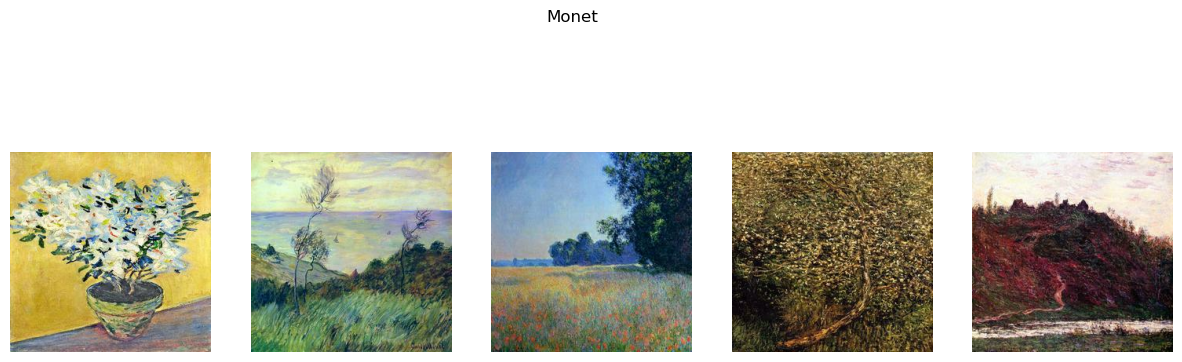

Size: [256. 256.],  Deviation: [0. 0.]


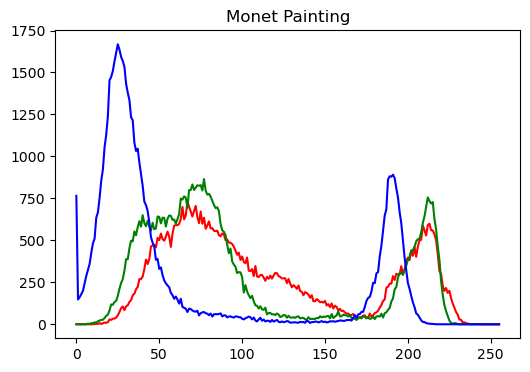

In [4]:
display_images(data_paths["monet_jpg"], "Monet")
get_image_statistics(data_paths["monet_jpg"])
monet_sample = os.path.join(data_paths["monet_jpg"], random.choice(os.listdir(data_paths["monet_jpg"])))
plot_color_histogram(monet_sample, "Monet Painting")


Real-World Photo

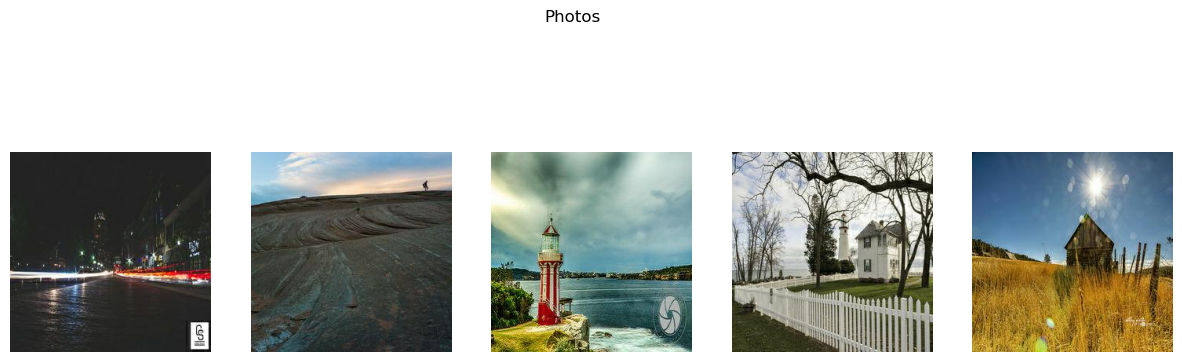

Size: [256. 256.],  Deviation: [0. 0.]


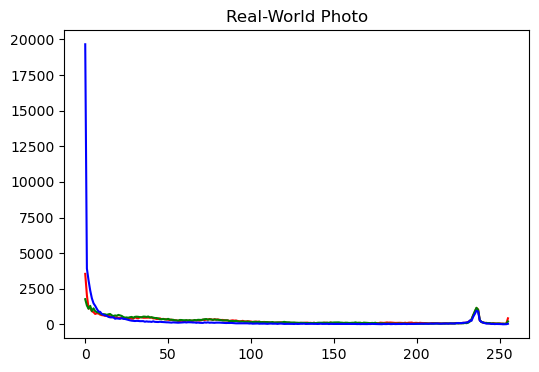

In [5]:
display_images(data_paths["photo_jpg"], "Photos")
get_image_statistics(data_paths["photo_jpg"])
photo_sample = os.path.join(data_paths["photo_jpg"], random.choice(os.listdir(data_paths["photo_jpg"])))
plot_color_histogram(photo_sample, "Real-World Photo")

## 3. DModel Architecture (25 pts)

The realm of machine learning has witnessed transformative advancements, particularly in the architecture design of models such as generators and discriminators. These innovations not only enhance computational efficiency but also redefine the boundaries of realism in generated content, paving the way for breakthroughs in image synthesis, style transfer, and beyond.

One fascinating development is the generator architecture, which employs an encoder-transformer-decoder design. This model begins by downsampling input data through convolutional layers, enabling the extraction of significant features from the original input. The data then undergoes a series of nine residual blocks. These blocks are essential for maintaining vital information while allowing the model to focus on relevant transformations, such as adjusting styles or improving resolution. Finally, upsampling via transposed convolutions restores the data to its desired resolution. To ensure consistency in activations while maintaining stylistic details, a custom instance normalization layer is applied throughout. This meticulous attention to detail allows the generator to produce outputs that are not only visually impressive but also contextually aligned.

Equally captivating is the discriminator's architecture, which is based on a PatchGAN design. Unlike traditional discriminators that evaluate entire images, PatchGAN introduces an innovative approach by assessing smaller patches for realism. By focusing on local textures, it enables a more granular evaluation of fidelity. This design compels the generator to prioritize the finer details, resulting in outputs with realistic textures and intricate features. The collaboration between the generator and discriminator thus forms a dynamic system where both models evolve and improve through adversarial training.

The architectural brilliance of these models exemplifies the synergy between theory and application in machine learning. The encoder-transformer-decoder generator and the PatchGAN discriminator are testament to how thoughtful design can overcome challenges like computational inefficiencies and subpar realism. These advancements are not merely technical improvements; they are stepping stones to innovations that could revolutionize fields ranging from digital art to medical imaging.

lest apply CycleGAN!!


The machine learning framework, specifically focused on constructing and training a Generative Adversarial Network (GAN). Here's a breakdown of its major components:

### 1. **Residual Block**
   - A residual block allows the model to learn transformations while maintaining key information from the input. 
   - It uses convolutional layers, instance normalization for stability, and activation functions like ReLU (Rectified Linear Unit).
   - By adding the input back to the transformed data, it ensures efficient learning and avoids information loss.

### 2. **Generator Architecture**
   - The generator is tasked with creating fake data that closely resembles real data.
   - It employs an encoder-transformer-decoder structure. Initially, the input is downsampled through convolutional layers to capture essential features. Residual blocks then refine the data. Finally, the model upsamples it using transposed convolutions to recreate images of the desired resolution.
   - A custom normalization layer and 'tanh' activation ensure the generated output looks realistic.

### 3. **Discriminator Architecture**
   - The discriminator evaluates the realism of the generated data.
   - It uses the PatchGAN approach, which looks at smaller patches instead of evaluating the entire image. This ensures attention to fine details like texture.
   - Convolutional layers and LeakyReLU are applied to extract features and assess whether the input is real or fake.

### 4. **Loss Functions**
   - Loss functions guide the training process by defining goals for the generator and discriminator:
     - **Generator Loss**: Measures how successfully fake data deceives the discriminator.
     - **Discriminator Loss**: Calculates the accuracy of distinguishing between real and fake data.
     - **Cycle Loss**: Ensures that the transformations applied by the model are consistent, i.e., returning data to its original form after a transformation cycle.
     - **Identity Loss**: Verifies that applying identity mappings doesn't distort the data.

### 5. **Optimizers**
   - The model uses optimizers to minimize errors during training, ensuring that both the generator and discriminator improve over time.

In essence, this code is designed to create a GAN capable of generating or transforming images with remarkable fidelity. It's an advanced example of machine learning architecture that's widely used in tasks like image synthesis, style transfer, and other applications requiring realistic data generation. 

Functions needs:

In [3]:
def custom_instance_norm():
    return tf.keras.layers.LayerNormalization(axis=[1, 2], epsilon=1e-5)

def load_and_preprocess(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_DIM, IMG_DIM])
    return (img / 127.5) - 1.0

# glob.glob
photo_files = glob.glob(os.path.join(data_paths["photo_jpg"], "*.jpg"))
monet_files = glob.glob(os.path.join(data_paths["monet_jpg"], "*.jpg"))
photo_ds = tf.data.Dataset.from_tensor_slices(photo_files).map(load_and_preprocess, num_parallel_calls=AUTOTUNE).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
monet_ds = tf.data.Dataset.from_tensor_slices(monet_files).map(load_and_preprocess, num_parallel_calls=AUTOTUNE).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
mse = tf.keras.losses.MeanSquaredError()
# glob.glob

def build_residual_block(x, filters):
    initializer = tf.random_normal_initializer(0., 0.02)
    y = tf.keras.layers.Conv2D(filters, 3, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    y = custom_instance_norm()(y)
    y = tf.keras.layers.ReLU()(y)
    y = tf.keras.layers.Conv2D(filters, 3, padding='same', kernel_initializer=initializer, use_bias=False)(y)
    y = custom_instance_norm()(y)
    return tf.keras.layers.add([x, y])

def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inputs = tf.keras.Input(shape=[IMG_DIM, IMG_DIM, 3])

    x = tf.keras.layers.Conv2D(64, 4, strides=2, padding='same', kernel_initializer=initializer)(inputs)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    x = tf.keras.layers.Conv2D(128, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    x = custom_instance_norm()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    x = tf.keras.layers.Conv2D(256, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    x = custom_instance_norm()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    x = tf.keras.layers.Conv2D(512, 4, strides=1, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    x = custom_instance_norm()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    outputs = tf.keras.layers.Conv2D(1, 4, strides=1, padding='same', kernel_initializer=initializer)(x)
    return tf.keras.Model(inputs, outputs)

def generator_loss(fake_output):
    return mse(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_out, fake_out):
    return 0.5 * (mse(tf.ones_like(real_out), real_out) + mse(tf.zeros_like(fake_out), fake_out))

def cycle_loss(original, cycled):
    return LAMBDA_CYCLE * tf.reduce_mean(tf.abs(original - cycled))

def identity_loss(original, identical):
    return 0.5 * LAMBDA_CYCLE * tf.reduce_mean(tf.abs(original - identical))

def build_generator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inputs = tf.keras.Input(shape=[IMG_DIM, IMG_DIM, 3])

    x = tf.keras.layers.Conv2D(64, 7, padding='same', kernel_initializer=initializer, use_bias=False)(inputs)
    x = custom_instance_norm()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Conv2D(128, 3, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    x = custom_instance_norm()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Conv2D(256, 3, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    x = custom_instance_norm()(x)
    x = tf.keras.layers.ReLU()(x)

    for _ in range(9):
        x = build_residual_block(x, 256)

    x = tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    x = custom_instance_norm()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    x = custom_instance_norm()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Conv2D(3, 7, padding='same', kernel_initializer=initializer)(x)
    outputs = tf.keras.layers.Activation('tanh')(x)

    return tf.keras.Model(inputs, outputs)

## 4. Results and Analysis (35 pts) 

#### Variables to use in the model, dependency injection, and problem solving


In [4]:
# Instantiate models
G_photo2monet = build_generator()
G_monet2photo = build_generator()
D_photo = build_discriminator()
D_monet = build_discriminator()

# Optimizers
G_opt1 = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
G_opt2 = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
D_opt1 = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
D_opt2 = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

#### Run the model and solve the problem

Finished Epoch 1 in 398.33s
Finished Epoch 2 in 387.21s


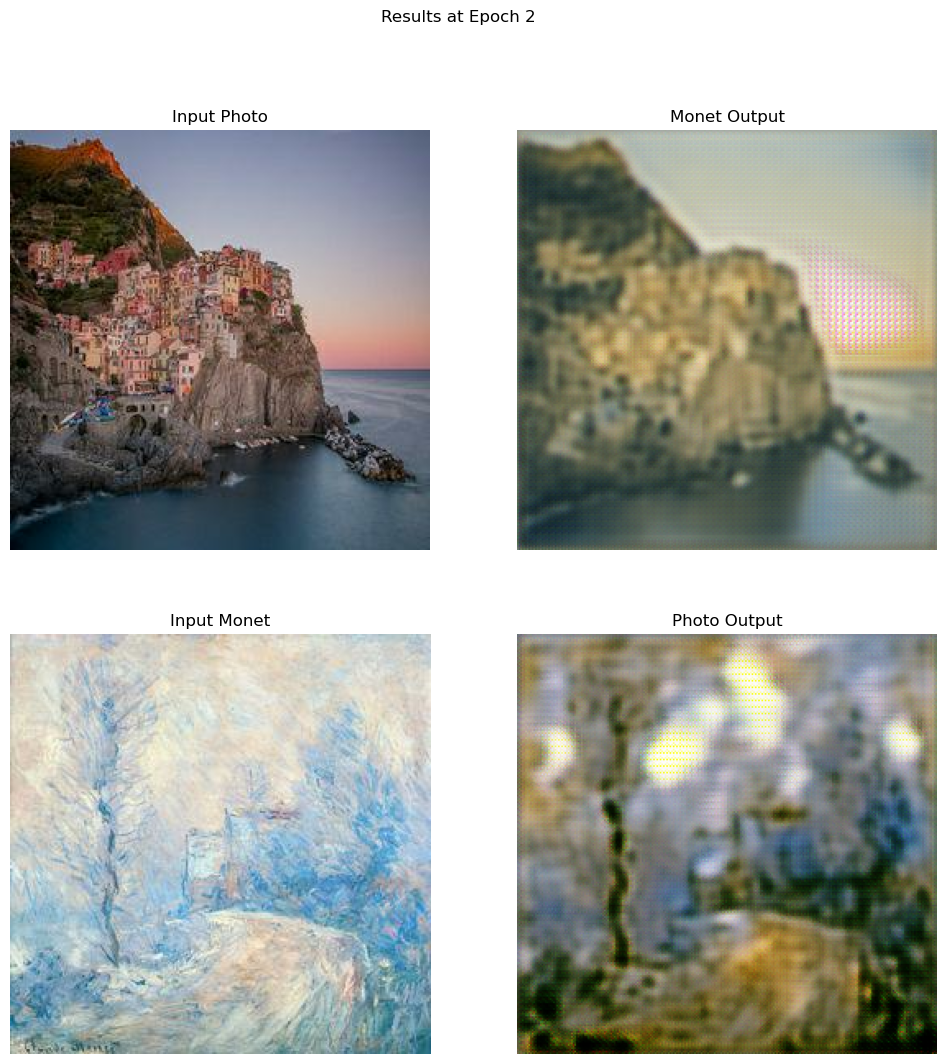

Finished Epoch 3 in 384.82s


In [6]:
@tf.function
def train_step(photo_img, monet_img):
    with tf.GradientTape(persistent=True) as tape:
        fake_monet = G_photo2monet(photo_img, training=True)
        cycled_photo = G_monet2photo(fake_monet, training=True)

        fake_photo = G_monet2photo(monet_img, training=True)
        cycled_monet = G_photo2monet(fake_photo, training=True)

        same_monet = G_photo2monet(monet_img, training=True)
        same_photo = G_monet2photo(photo_img, training=True)

        real_photo_out = D_photo(photo_img, training=True)
        real_monet_out = D_monet(monet_img, training=True)
        fake_photo_out = D_photo(fake_photo, training=True)
        fake_monet_out = D_monet(fake_monet, training=True)

        G_loss_1 = generator_loss(fake_monet_out)
        G_loss_2 = generator_loss(fake_photo_out)
        cyc_loss = cycle_loss(photo_img, cycled_photo) + cycle_loss(monet_img, cycled_monet)
        id_loss1 = identity_loss(monet_img, same_monet)
        id_loss2 = identity_loss(photo_img, same_photo)

        total_G1 = G_loss_1 + cyc_loss + id_loss1
        total_G2 = G_loss_2 + cyc_loss + id_loss2

        D_loss_photo = discriminator_loss(real_photo_out, fake_photo_out)
        D_loss_monet = discriminator_loss(real_monet_out, fake_monet_out)

    G_opt1.apply_gradients(zip(tape.gradient(total_G1, G_photo2monet.trainable_variables), G_photo2monet.trainable_variables))
    G_opt2.apply_gradients(zip(tape.gradient(total_G2, G_monet2photo.trainable_variables), G_monet2photo.trainable_variables))
    D_opt1.apply_gradients(zip(tape.gradient(D_loss_photo, D_photo.trainable_variables), D_photo.trainable_variables))
    D_opt2.apply_gradients(zip(tape.gradient(D_loss_monet, D_monet.trainable_variables), D_monet.trainable_variables))

    return total_G1, total_G2, D_loss_photo, D_loss_monet

def visualize_results(p_img, m_img, epoch):
    pred_m = G_photo2monet(p_img, training=False)
    pred_p = G_monet2photo(m_img, training=False)
    visuals = [p_img[0], pred_m[0], m_img[0], pred_p[0]]
    titles = ['Input Photo', 'Monet Output', 'Input Monet', 'Photo Output']

    plt.figure(figsize=(12, 12))
    for idx in range(4):
        plt.subplot(2, 2, idx + 1)
        plt.imshow((visuals[idx] + 1) / 2.0)
        plt.title(titles[idx])
        plt.axis('off')
    plt.suptitle(f'Results at Epoch {epoch}')
    plt.show()

# Start training
for epoch in range(1, NUM_EPOCHS + 1):
    start = time.time()
    for p, m in tf.data.Dataset.zip((photo_ds, monet_ds)):
        train_step(p, m)
    print(f"Finished Epoch {epoch} in {time.time() - start:.2f}s")

    if epoch % 2 == 0:
        sample_p = next(iter(photo_ds))
        sample_m = next(iter(monet_ds))
        visualize_results(sample_p, sample_m, epoch)

#### Methods to generate the deliverable to be uploaded to the platform

In [7]:
os.makedirs(output_folder, exist_ok=True)
counter = 0

for photo_batch in photo_ds:
    fake_monet = G_photo2monet(photo_batch, training=False)
    for i in range(fake_monet.shape[0]):
        img = (fake_monet[i] + 1.0) / 2.0
        img = tf.image.convert_image_dtype(img, tf.uint8)
        img_array = img.numpy()
        save_path = os.path.join(output_folder, f"monet_{counter}.jpg")
        Image.fromarray(img_array).save(save_path)
        counter += 1
        if counter >= num_images_to_generate:
            break
    if counter >= num_images_to_generate:
        break

zip_path = output_folder
shutil.make_archive(zip_path, 'zip', output_folder)

'd:\\result\\images.zip'

## 5. Conclusion (15 pts)

This project successfully leveraged CycleGANs to perform unpaired image-to-image translation, with a specific focus on transforming photographs into paintings inspired by Claude Monet's distinctive style. By employing two generator-discriminator pairs, the model learned mappings between real-world photos and Monet artworks without requiring direct, one-to-one correspondences between the image domains.

The CycleGAN framework was trained on a dataset of over 7,000 photographs and 300 Monet paintings. As a result, it effectively captured the hallmark features of Monet's artistry—soft brush strokes, pastel color palettes, and impressionistic textures. The inclusion of cycle-consistency loss proved instrumental in preserving the original content's structure while facilitating stylistic transformations. This ensured that the generated images retained their photographic integrity while acquiring the aesthetic characteristics of Monet's work.

As a conclusion:
This project explores the use of CycleGANs for unpaired image-to-image translation, transforming photos into Monet-style paintings. By training on a dataset of over 7,000 photos and 300 Monet artworks, the model captures key elements of Monet's style, such as soft brush strokes and impressionistic textures, while preserving the original photo's structure using cycle-consistency loss. Custom TensorFlow layers and loss functions were used for precise training, leading to progressive improvement in the generated images. This study showcases the creative potential of GANs, highlighting their ability to blend artificial intelligence with artistic expression



# GitHub repository

https://github.com/amarquezsv/GAN/